In [3]:
# Импорт библиотек
# Библиотека networkx (networkx.org) - библиотека для работы с графами
# Потребуется только для хранения графа
import networkx as nx

import pandas as pd
import heapq
import math
import random

# Будем рисовать анимации в Jupyter для понимания процесса работы алгоритма
import matplotlib.animation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

In [4]:
# Получим данные по ссылке, указанной выше
df = pd.read_csv("https://paste.sr.ht/blob/8ce2a2a7668a09cd852bc59f3987ef126ffe4bc3")

# Соберём вершины графа
pub_dict = df.to_dict('index')
g = nx.Graph()
g.add_nodes_from(pub_dict)

# Создадим словарь с широтой и долготой вершин графа
pos_dict = { k: (v['lon'], v['lat']) for k,v in pub_dict.items() }

# Сколько всего вершин
len(g.nodes())

92

In [5]:
# Функция dist считает расстояние в градусах
# между вершинами с индексами idx1 и idx2
def dist(idx1: int, idx2: int) -> float:
  (p1x,p1y) = pos_dict.get(idx1)
  (p2x,p2y) = pos_dict.get(idx2)
  dx = p2x - p1x
  dy = p2y - p1y
  return math.sqrt(dx*dx + dy*dy)

In [6]:
# Сколько градусов можем пройти
WALK_DIST = 0.02

# Добавляем в граф наши рёбра
g.clear_edges()
for k, v in pub_dict.items():
  edges = set()
  min_edge = None
  for k2, v2 in pub_dict.items():
    if k != k2 and dist(k, k2) < WALK_DIST:
      edges.add((k, k2, dist(k, k2)))
    if k != k2 and (min_edge is None or min_edge[2] > dist(k, k2)):
      min_edge = (k, k2, dist(k, k2))
  if len(edges) == 0:
    edges.add(min_edge)
  g.add_weighted_edges_from(edges)

# Сколько всего получилось рёбер
len(g.edges())

873

In [7]:
def init_animation(g, pos):
  fig, ax = plt.subplots()
  return {'graph': g, 'pos': pos, 'fig': fig, 'ax': ax, 'frames': []}

def save_frame(an, title, visited, seen):
  an.get('frames').append({'title': title, 'visited': visited.copy(), 'seen': seen.copy()})

def draw_animation(an):
  G = an.get('graph')
  ax = an.get('ax')
  fig = an.get('fig')
  pos = an.get('pos')
  frames = an.get('frames')

  def update(num):
    ax.clear()

    frame = frames[num]
    title = frame.get('title')
    visited = frame.get('visited')
    seen = frame.get('seen')

    # Background nodes
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="gray")
    null_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=set(G.nodes()) - set(visited) - set(seen), node_color="white",  ax=ax)
    null_nodes.set_edgecolor("black")

    # Visited nodes
    vis_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=set(visited), node_color="black",  ax=ax)
    vis_nodes.set_edgecolor("black")

    # Seen nodes
    seen_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=set(seen), node_color="gray", ax=ax)
    seen_nodes.set_edgecolor("white")
    # nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(path,path)),  font_color="white", ax=ax)
    # edgelist = [path[k:k+2] for k in range(len(path) - 1)]
    # nx.draw_networkx_edges(G, pos=pos, edgelist=edgelist, width=idx_weights[:len(path)], ax=ax)

    # Scale plot ax
    ax.set_title("Frame %d:    "%(num+1) + " - " + title, fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])

  ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(frames), interval=1000, repeat=True)
  return HTML(ani.to_jshtml())

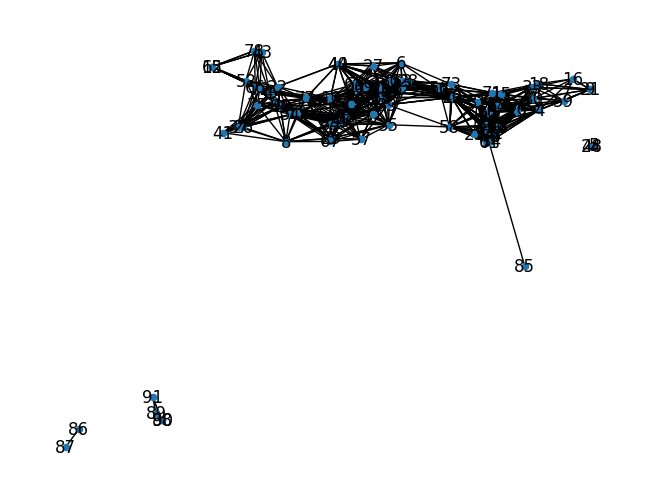

In [8]:
# Просто нарисуем граф со всеми вершинами и их номерами
node_labels_dict = { k: k for k, _v in pub_dict.items() }
nx.draw(g, pos=pos_dict, labels=node_labels_dict, node_size=20)
# Можем использовать spring_layout, чтобы видеть лучше (правда, это не поможет)
#     nx.draw(g, pos=nx.spring_layout(g), labels=node_labels_dict, node_size=20)

In [9]:
FROM = 41
# also can try: 48
TO = 85

In [ ]:
# Инициализируем анимацию. Если хотите реальные положения вершин, поменяйте на
#     an = init_animation(g, pos_dict)
an = init_animation(g, nx.spring_layout(g))

# Функция выполняет BFS из вершины start
def bfs(g, start):
  visited = {}
  visited[start] = True

  queue = [start]
  while queue:
    cur = queue.pop()

    # сохраняем кадр анимации
    save_frame(an, str(cur), visited, queue)

    # проходимся по соседям вершины cur
    for neighbour in g.neighbors(cur):
      if not visited.get(neighbour, False):
        visited[neighbour] = True
        queue.append(neighbour)

# Запустим BFS из исходной вершины
bfs(g, FROM)

# Нарисуем, что получилось
draw_animation(an)

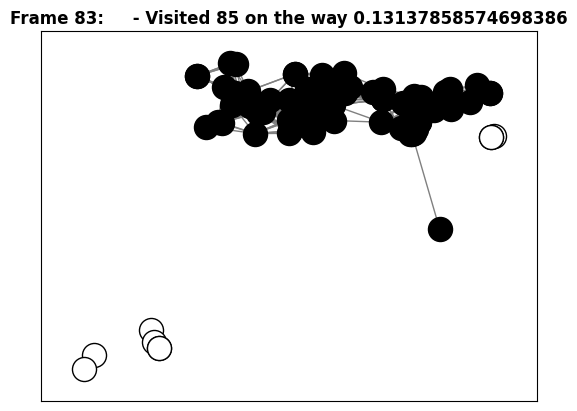

In [41]:
an = init_animation(g, pos_dict)
def dijkstra(g, start):
    distances = {node: float('inf') for node in g}
    distances[start] = 0
    queue = [(0, start)]

    visited = set()
    seen = set([start])

    while queue:
        current_distance, current_node = heapq.heappop(queue)

        if current_node in visited:
            continue

        visited.add(current_node)
        seen.discard(current_node)

        save_frame(an, f"Visited {current_node} on the way {current_distance}", visited, seen)

        for neighbor in g.neighbors(current_node):
            distance = g.edges[current_node, neighbor]['weight']
            new_distance = current_distance + distance


            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                heapq.heappush(queue, (new_distance, neighbor))
                seen.add(neighbor)



    return distances

dijkstra(g, FROM)

draw_animation(an)


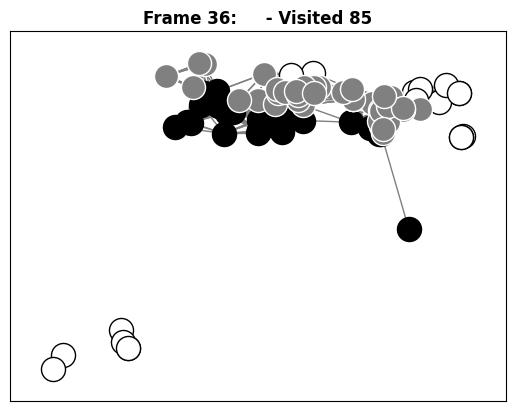

In [20]:
an = init_animation(g, pos_dict)
def astar(g, start):
    def h(node):
        return dist(node, TO)

    open_set = [(0, start)]
    came_from = {}
    distances = {node: float('inf') for node in g.nodes}
    distances[start] = 0
    f_score = {node: float('inf') for node in g.nodes}
    f_score[start] = h(start)

    open_set_hash = {start}
    visited = []
    seen = set()

    while open_set:
        _, current_node = heapq.heappop(open_set)
        open_set_hash.remove(current_node)

        visited.append(current_node)
        seen.discard(current_node)
        save_frame(an, f"Visited {current_node}", visited, seen)

        if current_node == TO:
            current = TO
            way = []
            while current in came_from:
                way.append(current)
                current = came_from[current]
            way.append(start)
            way.reverse()
            return way

        for neighbor in g.neighbors(current_node):
            new_distance = distances[current_node] + g.edges[current_node, neighbor]['weight']
            if new_distance < distances[neighbor]:
                came_from[neighbor] = current_node
                distances[neighbor] = new_distance
                f_score[neighbor] = distances[neighbor] + h(neighbor)
                if neighbor not in open_set_hash:
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
                    open_set_hash.add(neighbor)
                    seen.add(neighbor)

    return []

astar(g, FROM)

draw_animation(an)
